# Dimensionality Reduction

# PCA
Let's build a simple 3D dataset:

In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

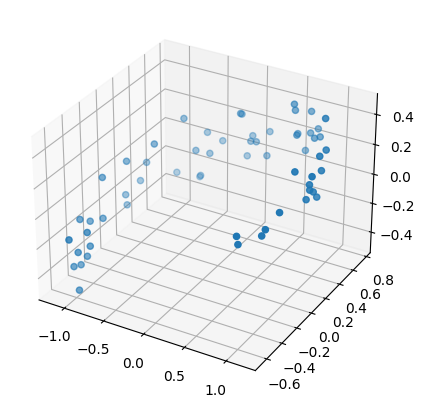

In [2]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0],X[:,1],X[:,2])

## Principal Components

In [3]:
Avg = X.mean(axis=0)
Std = X.std(axis=0)
X_centered = (X - Avg)/ Std

U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## Projecting Down to d Dimensions

In [6]:
W2 = Vt.T[:, :2]
X2D_using_svd = X_centered.dot(W2)

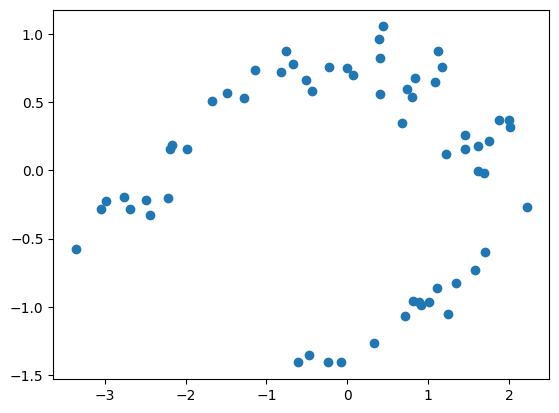

In [7]:
plt.scatter(X2D_using_svd[:,0], X2D_using_svd[:,1])

## Using Scikit-Learn

With Scikit-Learn, PCA is really trivial. It even takes care of mean centering for you:

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X_centered)

In [9]:
X2D[:5]

array([[ 2.68376956,  0.28559669],
       [-0.40523341, -0.55863105],
       [ 2.49003468,  0.21595091],
       [ 0.75299162, -0.87411153],
       [ 0.22487382, -0.75654968]])

In [10]:
X2D_using_svd[:5]

array([[-2.68376956, -0.28559669],
       [ 0.40523341,  0.55863105],
       [-2.49003468, -0.21595091],
       [-0.75299162,  0.87411153],
       [-0.22487382,  0.75654968]])

Notice that running PCA multiple times on slightly different datasets may result in different results. In general the only difference is that some axes may be flipped. In this example, PCA using Scikit-Learn gives the same projection as the one given by the SVD approach, except both axes are flipped:

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

Recover the 3D points projected on the plane (PCA 2D subspace).

In [12]:
X3D_inv = pca.inverse_transform(X2D)
X3D_inv = X3D_inv * Std + Avg

Of course, there was some loss of information during the projection step, so the recovered 3D points are not exactly equal to the original 3D points:

In [13]:
np.allclose(X3D_inv, X)

False

We can compute the reconstruction error:

In [ ]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

The inverse transform in the SVD approach looks like this:

In [15]:
X3D_inv_using_svd = X2D_using_svd.dot((Vt.T[:, :2]).T)
X3D_inv_using_svd = X3D_inv_using_svd * Std + Avg

In [16]:
np.allclose(X3D_inv_using_svd, X3D_inv)

True

The `PCA` object gives access to the principal components that it computed:

In [17]:
pca.components_

array([[-0.53369802, -0.57453367, -0.62054612],
       [ 0.79334984, -0.59425498, -0.13212513]])

Compare to the first two principal components computed using the SVD method:

In [18]:
Vt[:2]

array([[ 0.53369802,  0.57453367,  0.62054612],
       [-0.79334984,  0.59425498,  0.13212513]])

Notice how the axes are flipped.

## Explained Variance Ratio

Now let's look at the explained variance ratio:

In [19]:
pca.explained_variance_ratio_

array([0.77570201, 0.17134639])

The first dimension explains 77.6% of the variance, while the second explains 17.1%.

By projecting down to 2D, we lost about 5.3% of the variance:

In [20]:
1 - pca.explained_variance_ratio_.sum()

0.052951595558146325

Here is how to compute the explained variance ratio using the SVD approach (recall that `s` is the diagonal of the matrix `S`):

In [21]:
np.square(s) / np.square(s).sum()

array([0.77570201, 0.17134639, 0.0529516 ])

Next, let's generate some nice figures! :)
Explor the dimensions vs. explained varianc

Text(0, 0.5, 'Explained Variance')

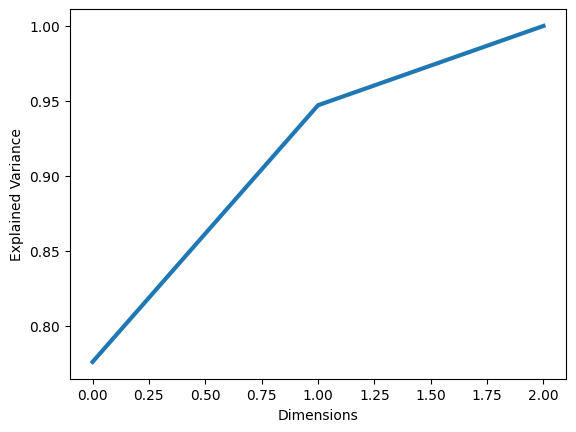

In [22]:
pca2 = PCA()
X_new=pca2.fit_transform(X_centered)
cumsum = np.cumsum(pca2.explained_variance_ratio_)
plt.plot(cumsum, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

## Choosing the Right Number of Dimensions

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

In [24]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]
avg = X.mean(axis=0)
std = X.std(axis=0)
X_centered = (X - avg) / (std + 1e-9)
X_train, X_test, y_train, y_test = train_test_split(X_centered, y)

In [25]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [26]:
d

325

**Code to generate Figure 8–8. Explained variance as a function of the number of dimensions:**

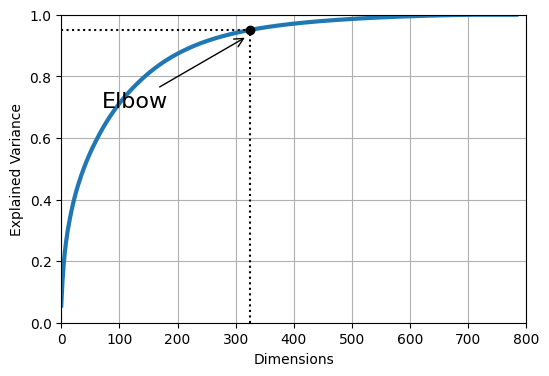

In [27]:
import os
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 800, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(320, 0.93), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [28]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [29]:
pca.n_components_

325

In [30]:
np.sum(pca.explained_variance_ratio_)

0.9503040964476793

# LLE

In [31]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
print(X.shape)
print(t.shape)

(1000, 3)
(1000,)


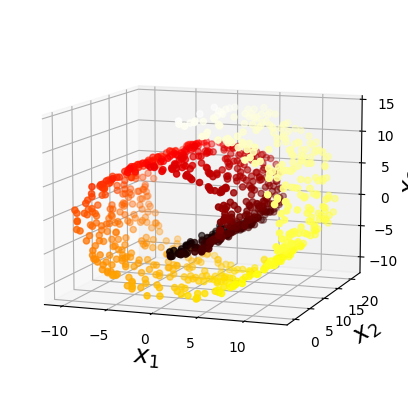

In [33]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)                   # Change the Angle of view
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [34]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)
print(X_reduced.shape)

(1000, 2)


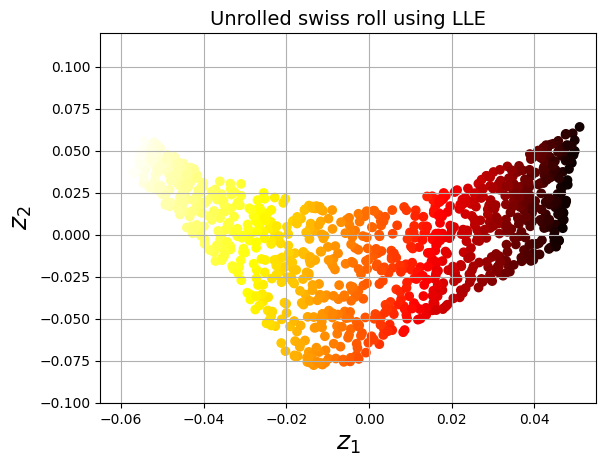

In [35]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

# MDS, Isomap and t-SNE

In [36]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)
print('The output shape of MDS method: ', X_reduced_mds.shape)

The output shape of MDS method:  (1000, 2)


In [37]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)
print('The output shape of Isomap method: ', X_reduced_isomap.shape)

The output shape of Isomap method:  (1000, 2)


In [38]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)
print('The output shape of TSNE method: ', X_reduced_tsne.shape)

The output shape of TSNE method:  (1000, 2)


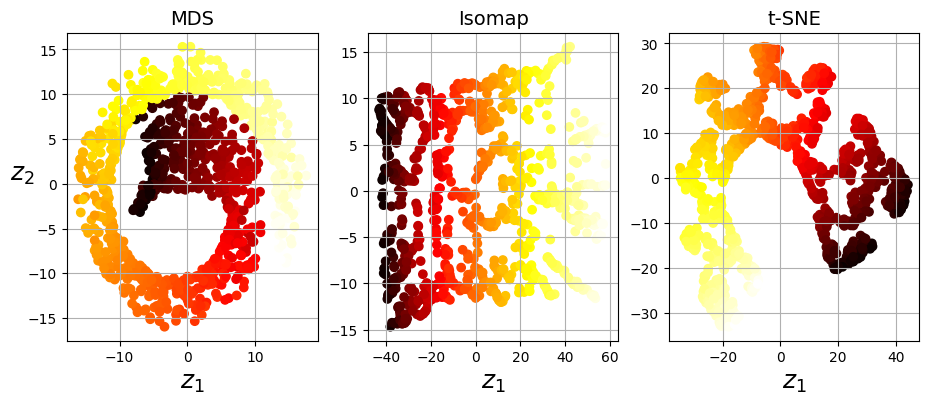

In [39]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# Exercise 

Use MNIST data to apply PCA

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# get the data
mnist = fetch_openml('mnist_784', version=1,as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X_mnist=mnist.data[:6000]
print(X_mnist.shape)

avg = X_mnist.mean(axis=0)
std = X_mnist.std(axis=0)
X_centered = (X_mnist - avg) / (std + 1e-9)

In [ ]:
# apply pca 
pca_minst = PCA(n_components=0.95)
X_reduced = pca_minst.fit_transform(X_centered)
print('The Compressed Shape After PCA : ', X_reduced.shape)

# recover from the reduced data
X_recovered = pca_minst.inverse_transform(X_reduced)
X_recovered = X_recovered * std + avg
print('The Recoverd Data Shape : ', X_recovered.shape)

# visualize and compare the diffrence between the compressed and original
index=0
plt.figure(figsize=(7, 4))
plt.subplot(121)
plt.imshow(X_mnist[index].reshape(28,28), cmap="binary")
plt.title("Original", fontsize=16)
plt.subplot(122)
plt.imshow(X_recovered[index].reshape(28,28),cmap="binary")
plt.title("Compressed", fontsize=16)

In [ ]:
#  explore the relation of explained variance and dimensions
# initial a pca_all captures the entile components and the explained variance ratio
pca_all = PCA()
X_all= pca_all.fit_transform(X_centered)
cumsum = np.cumsum(pca_all.explained_variance_ratio_)
plt.figure(figsize=(7, 4))
plt.plot(cumsum, linewidth=3)
plt.grid(True)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.axis([0, 800, 0, 1])

plt.plot([270, 270], [0, 0.95], "k:")
plt.plot([0, 270], [0.95, 0.95], "k:")
plt.plot(270, 0.95, "ko")
plt.annotate("Elbow", xy=(260, 0.93), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()